# Abstract Interpretation of SPARK Programs

Traditionally, SPARK programs have been analysed by the Examiner using data flow and information flow analysis.  This study does not consider the proof features of the Examiner (VCG generator) but rather investigates whether the same or better analysis can be achieved using abstract interpretation as the current flow analysis techniques. Better results may be achievable using abstract interpretation as it might be possible to determine some non-executable paths and exclude them from the analysis.  To achieve this goal, two of the more advanced techniques of abstract interpretation - variable analysis and path analysis are needed. 

The SPARK language was developed to achieve accurate and straightforward flow analysis. Many of the restrictions placed on Ada by SPARK to make it amenable to flow analysis may also be advantageous for abstract interpretation.  


## Abstract Interpretation
Abstract interpretation is commonly viewed as having three stages:
1. Translate
2. Merge
3. Widen

These three stages are applied to each statement of the given source text until it has been completed.
Translate converts a statement into an abstraction representing the statement.  Merge takes the abstractions of the current and immediately preceding statements (in general, there may be more than one due to gotos if statements and loops) and merges them into a single abstraction for the statement.  Widen is typically used after loops to widen the approximation to represent executing the loop multiple times.

What is interesting about these stages is that they can be adapted to suit a number of different analyses but still fit within the framework of calling each of the three stages for each statement.

For instance,  constant analysis is may be used to obtain an approximation of the range of values a variable may have at a particular statement based on the value of constants within the source text.  Variable analysis is similar but more complex based on the expressions assigned to variables within the source text.

To perform abstract interpretation, an abstract model of the source text needs to be constructed consisting of a model of each statement (the translation) and a sequence of abstractions representing each of the previous statements.  Te abstracion consists of an abstract state for each variable in scope. Merge consolidates the immediately preceding statements with the model of the current statement to obtain an abstraction for the current statement which is appended to the sequence.  Merging is a simple operationwhen the statement has only one immediate predecessor but becomes a little more complex around if statements, loops and the targets of goto statements.

SPARK has the advantage over general programming in that, other than in a loop, an immediately preceding statement cannot be later in text than the current statement, simplifying the sequence of preceding statements that need to be maintained.  As SPARK is modular and each subprogram is essentially self-contained and only variables used within the subprogram need to be in the abstractions, very little extra context has to be maintained and the sequence of abstractions can be discarded after completing the analysis of the subprogram.

This study starts with the simple but very important check for SPARK variable defindness.   In Ada terms, is every variable initialised to a valid value before it is read?

## Abstract Interpretation of Defindness
Consider a model to represent defindness. Each variable may have a few possible states:

1. Uninitialized
2. Read
3. Assigned
4. Unsound

The first three states are obvious and, unsound, represents a variable that is assigned from an uninitialised variable or an unsound variable and may have an invalid value.

In a single statement a variable may be both read and assigned but in SPARK expressions do not have side-effects so the all the variables on the right hand side of an assignment statement are only read.  On the left hand side only array indices are read although, unusually in object dclarations, more than one variable may be assigned.  Assignment also occurs to actual parameters of mode **out** or **in out** in a procedure call statement and a procedure can have multiple **out** and **in out**  parameters.

The proposed translation first considers all of variables read by the statement and then those that are assigned by the statement. This avoids ambiguity when a variable is both read and written by the statement.  Each read and assignment of a variable will have a separate entry in the translation.  For instance:

    X := X + X + Y;

would be translated as:

    X -> Read
    X -> Read
    Y -> Read
    X -> Assigned

To keep an association between the model and the statement a statement position and a model item is needed.  For simplicity, in this study, only one statement per line is assumed and so the position can just be the line number.

Assuming the above statement is on line 10, the translation becomes:

    X -> Read (10, 1)
    X -> Read (10, 2)
    Y -> Read (10, 3)
    X -> Assigned (10, 4)

It may not be necessary to record the two reads of X, one may be sufficient as a read does not change the state of the variable.

The abstraction representing the statement is constructed from the above model and its immediately preceeding statements by the merge operation. Commonly, an abstraction has a notion of the range of values that a variable may have at the statement.  For defindness the maximum range is Undefined .. Unsound, athough in defindness there is not necessarily an order to these posible states.  A merge has to take the abstractions from the immediately preceding statements and the model of the statement form this pair of states.

Some rules are needed for merge, for the moment consider only simple source text which has no if, or loop statements (straight line code):

    Previous State        Statement Model  Merged State   
    Uninitialized <merge> Read           -> Unsound  --  Use of an uninitialised variable
    Uninitialized <merge> Assigned       -> Assigned
    Read          <merge> Read           -> Read
    Read          <merge> Assigned       -> Assigned
    Assigned      <merge> Read           -> Read
    Assigned      <merge> Assigned       -> Assigned --  Previously assigned value unused
    Unsound       <merge> Read           -> Unsound  --  The value read may be unsound
    Unsound       <merge> Assigned       -> Assigned

In SPARK there is not a statement to Uninitialise a variable or to set it as unsound so these states do not appear in the Statement Model above.  A variable is uninitialised when declared, so the model of a declaration is Uninitialised but it has no previous state.  The Unsound state can only be entered by a Read of an Uninitialised state or the Read of an Unsound state. Consequently, if a Previous State is Read then it must have previously been Assigned.  

As the abstraction has a pair of states to represent the "range" of values a variable might have at a paricular statement, the Previous State for the variable forms one of the pair and the newly merged state is the other.

When There is more than one immediately preceding statement (in SPARK after an if, case or loop statement) these rules will have to be applied for each predecessor and then the state pairs could show a significant difference depending on the path taken eg., (Assigned, Uninitialised) meaning that on one path the variable associated with the state pair is Uninitialised. 

### Straight Line Code

First, consider the following simple SPARK procedure taken from early SWES courses.

    procedure Swap (X : in out Integer; Y : in out Integer) is
      Temp : Integer;
    begin
      Temp := X;
      X := Y;
      Y := Temp;
    end Swap;

As it is written there are no uses of uninitialised variables.

Using the ideas for models and abstractions the following spread sheet was constructed to demonstrate using abstract interpretation to check for defindness.

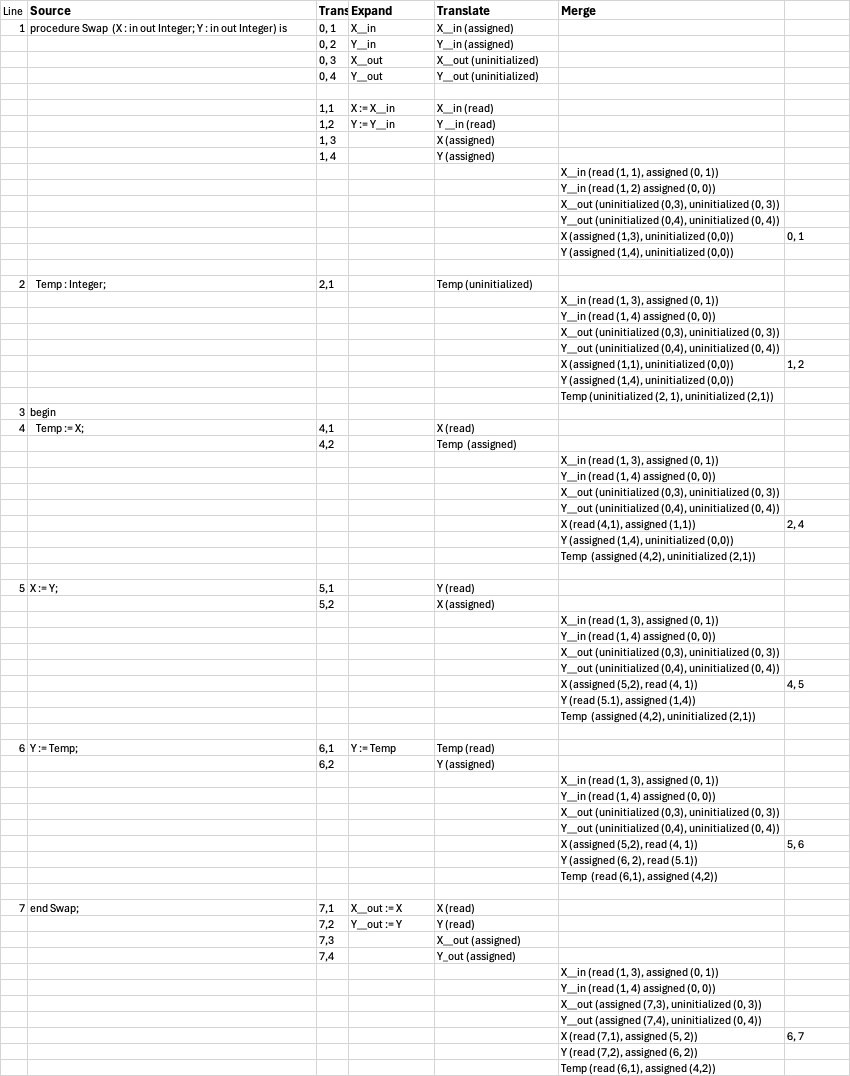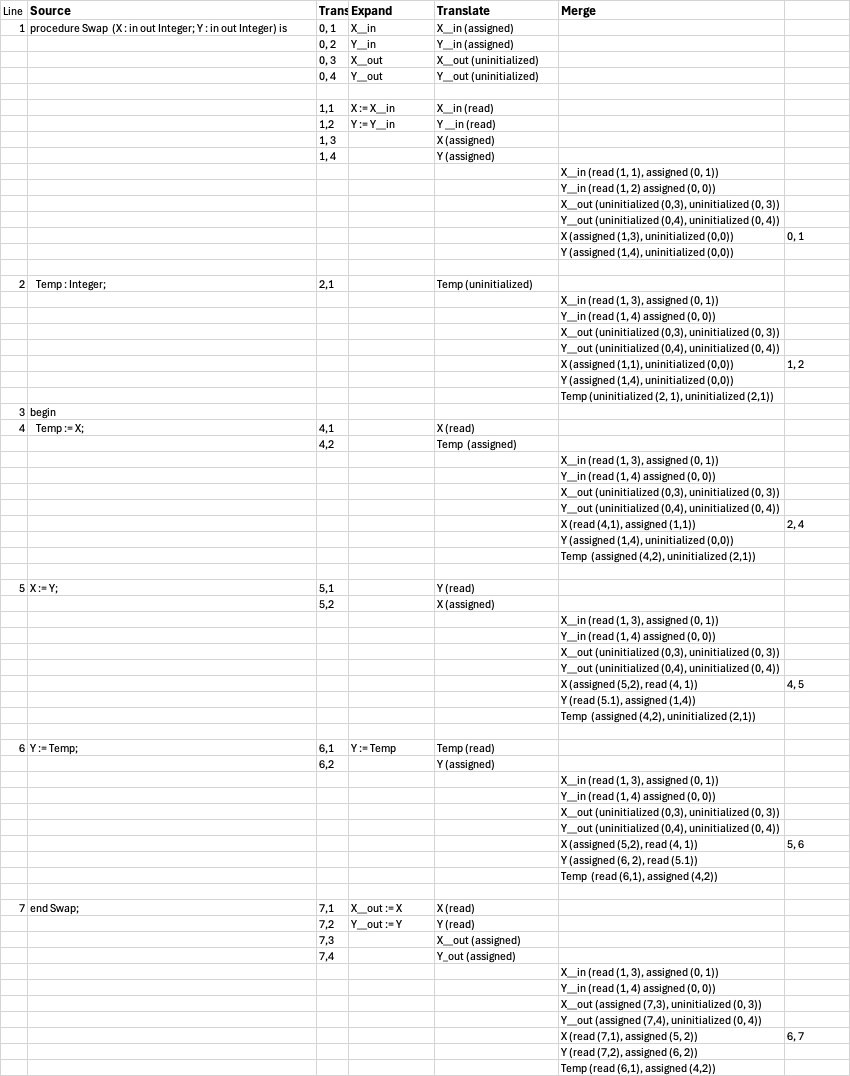